In [84]:
# ---
# 🧬 BM4322 Genomic Signal Processing
# Promoter Detection and Statistical Alignment
# Academic Year 2025/2026 - Semester 7
# ---

# Import required libraries
from Bio import SeqIO, motifs
from Bio.Seq import Seq
import pandas as pd
import numpy as np
import ast
import logomaker
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [86]:
# -------------------------------------------------------
# Loading pre-extracted upstream sequences
# -------------------------------------------------------

# The file 'upstream_seqs.txt' contains a list of 15→5 bp upstream sequences
# for 1100 genes, extracted using genome and GFF annotation files
with open("upstream_seqs_210732H.txt", "r") as f:
    upstream_seqs_final = ast.literal_eval(f.read().strip())

print(f"Total upstream sequences loaded: {len(upstream_seqs_final)}")

Total upstream sequences loaded: 1100


In [90]:
# -------------------------------------------------------
# 2️⃣ Load genome and GFF annotation files
# -------------------------------------------------------

# These would typically be provided for the assigned genome.
# Example usage:
genome_file = "NCBI_Data/210732H_GCA_019046945.1/ncbi_dataset/data/GCA_019046945.1/GCA_019046945.1_ASM1904694v1_genomic.fna"       # Replace with your assigned genome file
gff_file = "NCBI_Data/210732H_GCA_019046945.1/ncbi_dataset/data/GCA_019046945.1/genomic.gff"     # Replace with your corresponding GFF file



In [91]:
# Read genome sequence
genome_record = SeqIO.read(genome_file, "fasta")
genome_seq = str(genome_record.seq)

In [92]:
# Read GFF annotation table
gff_cols = ["seqid","source","type","start","end","score","strand","phase","attributes"]
gff_df = pd.read_csv(gff_file, sep="\t", comment="#", names=gff_cols)

print(f"Total annotated entries: {len(gff_df)}")

Total annotated entries: 4309


In [93]:
# -------------------------------------------------------
# 3️⃣ Extract upstream regions for genes predicted by homology
# -------------------------------------------------------

def extracting_bases(genome_seq, gff_df, upstream_seqs_final):
    """
    Extract 15→5 bp upstream regions for all genes predicted via protein homology,
    and identify possible promoter-like sequences (WAWWWT).
    """
    genes_df = gff_df[(gff_df["source"] == "Protein Homology")]
    upstream_seqs = []

    for _, row in genes_df.iterrows():
        start = int(row["start"]) - 1 
        
        # Extract upstream depending on strand orientation
        if row["strand"] == "+":
            upstream_start = max(0, start - 15)
            upstream_end = max(0, start - 5)
            seq = genome_seq[upstream_start:upstream_end]
        else:  # antisense strand → reverse complement of downstream region
            upstream_start = start + 5  
            upstream_end = start + 15   
            seq = genome_seq[upstream_start:upstream_end]
            seq = str(Seq(seq).reverse_complement())  

        upstream_seqs.append(seq)

    # Identify 6-base regions likely forming the promoter (WAWWWT)
    promoter_seqs = []
    for seq in upstream_seqs_final[:100]:  # use only first 100 sequences
        for i in range(len(seq) - 5):
            window = seq[i:i+6]
            # Heuristic check: all A/T bases, 2nd base A, last base T
            if all(base in "AT" for base in window) and window[1]=='A' and window[-1]=='T':
                promoter_seqs.append(window)

    return promoter_seqs



In [113]:

promoter_seqs = extracting_bases(genome_seq, gff_df, upstream_seqs_final)
print(f"Promoter-like sequences found: {len(promoter_seqs)}")

Promoter-like sequences found: 10


In [114]:

# -------------------------------------------------------
# 4️⃣ Construct the Position Probability Matrix (PPM)
# -------------------------------------------------------

def create_ppm(promoter_seqs):
    """
    Create a PPM from extracted promoter sequences and
    compute consensus and consensus score.
    """
    promoter_motifs = motifs.create([Seq(i) for i in promoter_seqs])

    # Add small pseudocounts for missing bases (heuristic)
    for i in range(6):
        for base in "ATCG":
            if promoter_motifs.counts[base][i] == 0:
                promoter_motifs.counts[base][i] = 0.001

    # Normalize counts to obtain probability matrix
    ppm = promoter_motifs.counts.normalize()

    # Compute consensus and its score
    consensus = promoter_motifs.consensus
    consensus_score = np.log((ppm["A",0]*ppm["A",1]*ppm["A",2]*
                       ppm["A",3]*ppm["A",4]*ppm["T",5]))

    return ppm, consensus, consensus_score

In [115]:
ppm, consensus, consensus_score = create_ppm(promoter_seqs)
print(f"Consensus motif: {consensus}")
print(f"Consensus score: {consensus_score:.4e}")

Consensus motif: AAAAAT
Consensus score: -1.7570e+00


In [120]:
# -------------------------------------------------------
# 5️⃣ Perform statistical alignment on remaining 1000 regions
# -------------------------------------------------------

def statistical_alignment(upstream_seqs_final, ppm, consensus_score):
    """
    Perform alignment of each 6-base window in the remaining 1000 upstream regions
    against the promoter PPM, and compute log-normalized scores.
    """
    norm_score = {}

    for idx, seq in enumerate(upstream_seqs_final[100:]):  # remaining 1000 sequences
        seq_scores = {}
        for i in range(len(seq) - 5):
            window = seq[i:i+6]
            window_score = (ppm[window[0], 0] * ppm[window[1], 1] *
                            ppm[window[2], 2] * ppm[window[3], 3] *
                            ppm[window[4], 4] * ppm[window[5], 5])
            seq_scores[window] = np.log(window_score) - consensus_score
        norm_score[idx] = seq_scores

    # Print high-scoring promoter-like windows
    threshold = -1.757020252640843
    for i in range(1000):
        for j in norm_score[i]:
            if norm_score[i][j] > threshold:
                print(f"Sequence index: {i}, Window: {j}, Normalized Score: {norm_score[i][j]}")

    return norm_score

In [121]:

norm_score = statistical_alignment(upstream_seqs_final, ppm, consensus_score)

Sequence index: 29, Window: TATAAT, Normalized Score: -0.810930216216329
Sequence index: 29, Window: TAATAT, Normalized Score: -0.810930216216329
Sequence index: 40, Window: AAAAAT, Normalized Score: 0.0
Sequence index: 40, Window: AAAATT, Normalized Score: -1.3862943611198906
Sequence index: 102, Window: AAAAAT, Normalized Score: 0.0
Sequence index: 126, Window: AAAAAT, Normalized Score: 0.0
Sequence index: 126, Window: AAAATT, Normalized Score: -1.3862943611198906
Sequence index: 153, Window: TAAAAT, Normalized Score: -0.40546510810816483
Sequence index: 251, Window: TATAAT, Normalized Score: -0.810930216216329
Sequence index: 280, Window: TATAAT, Normalized Score: -0.810930216216329
Sequence index: 310, Window: TAAAAT, Normalized Score: -0.40546510810816483
Sequence index: 330, Window: TAAAAT, Normalized Score: -0.40546510810816483
Sequence index: 332, Window: AAAAAT, Normalized Score: 0.0
Sequence index: 349, Window: AAAAAT, Normalized Score: 0.0
Sequence index: 382, Window: TATAAT

<Figure size 800x300 with 0 Axes>

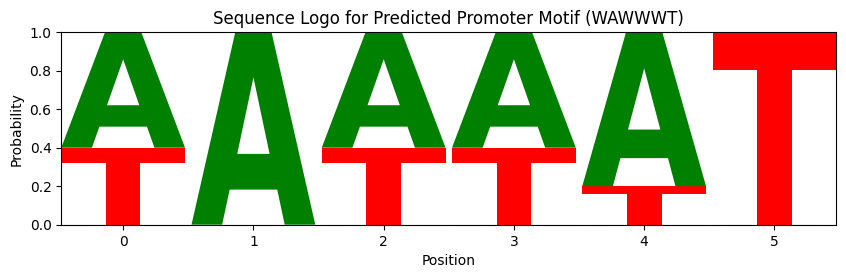

In [122]:
# -------------------------------------------------------
# 6️⃣ Visualize alignment score distribution
# -------------------------------------------------------


# Assuming you have promoter_motifs_counts as a list of lists (6 x 4)
bases = ['A','C','G','T']
df = pd.DataFrame(ppm, columns=bases)

plt.figure(figsize=(8,3))
logomaker.Logo(df, color_scheme='classic')
plt.title('Sequence Logo for Predicted Promoter Motif (WAWWWT)')
plt.xlabel('Position')
plt.ylabel('Probability')
plt.show()


In [123]:
import pandas as pd
from IPython.display import display

bases = ['A','C','G','T']
ppm_df = pd.DataFrame(ppm, columns=bases)
ppm_df.index = [f'Pos {i+1}' for i in range(6)]

display(ppm_df.round(7))

,A,C,G,T
Pos 1,0.59988,0.0001,0.0001,0.39992
Pos 2,0.99970,0.0001,0.0001,0.00010
Pos 3,0.59988,0.0001,0.0001,0.39992
Pos 4,0.59988,0.0001,0.0001,0.39992
Pos 5,0.79984,0.0001,0.0001,0.19996
Pos 6,0.00010,0.0001,0.0001,0.99970


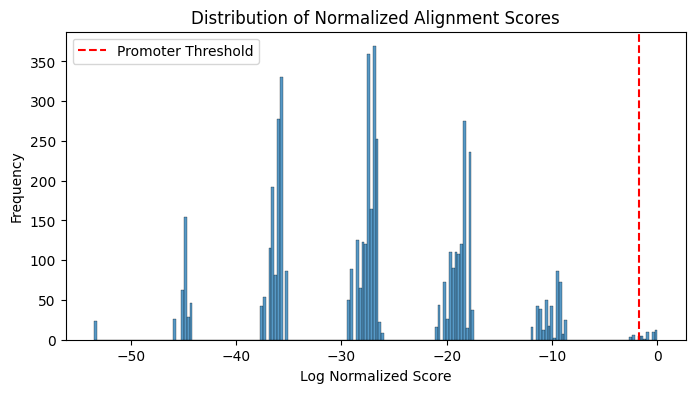

In [124]:
all_scores = [score for seq in norm_score.values() for score in seq.values()]

plt.figure(figsize=(8,4))
sns.histplot(all_scores, bins=200, kde=False)
plt.title('Distribution of Normalized Alignment Scores')
plt.xlabel('Log Normalized Score')
plt.ylabel('Frequency')
plt.axvline(-1.757, color='r', linestyle='--', label='Promoter Threshold')
plt.legend()
plt.show()

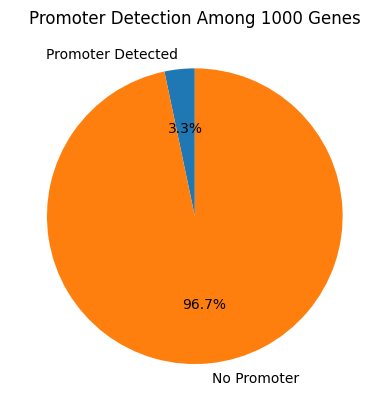

In [125]:
threshold = -1.757
promoter_presence = [any(score > threshold for score in seq.values()) for seq in norm_score.values()]

present = sum(promoter_presence)
absent = len(promoter_presence) - present

plt.pie([present, absent], labels=['Promoter Detected','No Promoter'], autopct='%1.1f%%', startangle=90)
plt.title('Promoter Detection Among 1000 Genes')
plt.show()


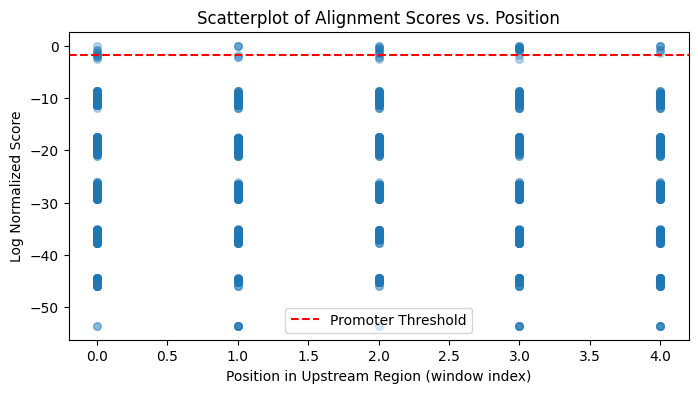

In [126]:
positions, scores = [], []
for seq_scores in norm_score.values():
    for i, (window, score) in enumerate(seq_scores.items()):
        positions.append(i)
        scores.append(score)

plt.figure(figsize=(8,4))
plt.scatter(positions, scores, alpha=0.3, s=30)
plt.axhline(-1.757, color='r', linestyle='--', label='Promoter Threshold')
plt.title('Scatterplot of Alignment Scores vs. Position')
plt.xlabel('Position in Upstream Region (window index)')
plt.ylabel('Log Normalized Score')
plt.legend()
plt.show()


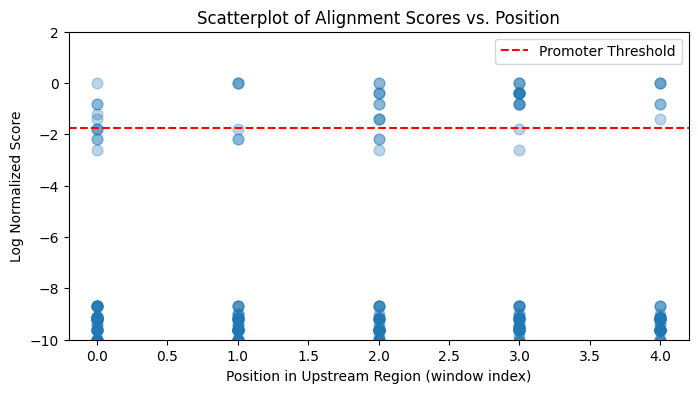

In [127]:
plt.figure(figsize=(8,4))
plt.scatter(positions, scores, alpha=0.3, s=60)
plt.axhline(-1.757, color='r', linestyle='--', label='Promoter Threshold')
plt.title('Scatterplot of Alignment Scores vs. Position')
plt.xlabel('Position in Upstream Region (window index)')
plt.ylabel('Log Normalized Score')
plt.legend()
plt.ylim(-10, 2)
plt.show()
